In [3]:
######## timecorr vs sliding window, different variances & ramp correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [1000,1250,1500,1750]
sliding_window_length = 51
repetitions=1
var_num = len(variance)

block_length = 1
covariance_num = 1000
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map,feature_map.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map1,feature_map1.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations[:,i] = np.dot(cholesky(correlations[i]),activations[:,i])

lower_limit, upper_limit = sliding_window_length/2, time_len-sliding_window_length/2
time_range = upper_limit - lower_limit

timecorr_correlations1,timecorr_correlations2 = np.zeros([var_num,time_len-sliding_window_length+1]),np.zeros([var_num,time_len-sliding_window_length+1])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_MSE1,timecorr_MSE2 = np.zeros([var_num,time_len-sliding_window_length+1]),np.zeros([var_num,time_len-sliding_window_length+1])
sliding_window_MSE1,sliding_window_MSE2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_correlations_single = np.zeros([var_num,time_range])
sliding_window_correlations_single = np.zeros(time_range)

timecorr_MSE_single = np.zeros([var_num,time_range])
sliding_window_MSE_single = np.zeros(time_range)
color = ['b','r']

timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(var_num):
        timecorr_recovery[v] = wcorr(activations,variance[v])
    sliding_window_recovery = correlations
    for timepoint in range(time_len-sliding_window_length+1):
        for v in range(var_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            timecorr_MSE1[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
            timecorr_MSE2[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint+sliding_window_length/2], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+sliding_window_length/2]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))
        
        sc1 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation1,checks=False))[0]
        sliding_window_correlations1[timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
        sc2 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation2,checks=False))[0]
        sliding_window_correlations2[timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))
        
        sliding_window_MSE1[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation1,checks=False)))
        sliding_window_MSE2[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation2,checks=False)))
         
        swc = pearsonr(sliding_window_recovery[timepoint], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
        sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        
        sliding_window_MSE_single[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))        

timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions
sliding_window_MSE1/= repetitions
sliding_window_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("timecorr(solid), sliding window(dot)",fontsize=20)
a1[0].set_title("variance = 1000")
a1[1].set_title("variance = 1250")
a1[2].set_title("variance = 1500")
a1[3].set_title("variance = 1750")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(var_num): 
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0)
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0)
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1,c=color[0],linestyle='--',alpha=0.5)
    ax1.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2,c=color[1],linestyle='--',alpha=0.5)

    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE1,c=color[0],linestyle='--',alpha=0.5)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE2,c=color[1],linestyle='--',alpha=0.5)


    a3[v].plot(range(lower_limit,upper_limit),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a3[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
    a4[v].plot(range(lower_limit,upper_limit),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')
    a4[v].plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

plt.show()

IndexError: Out of bounds on buffer access (axis 1)

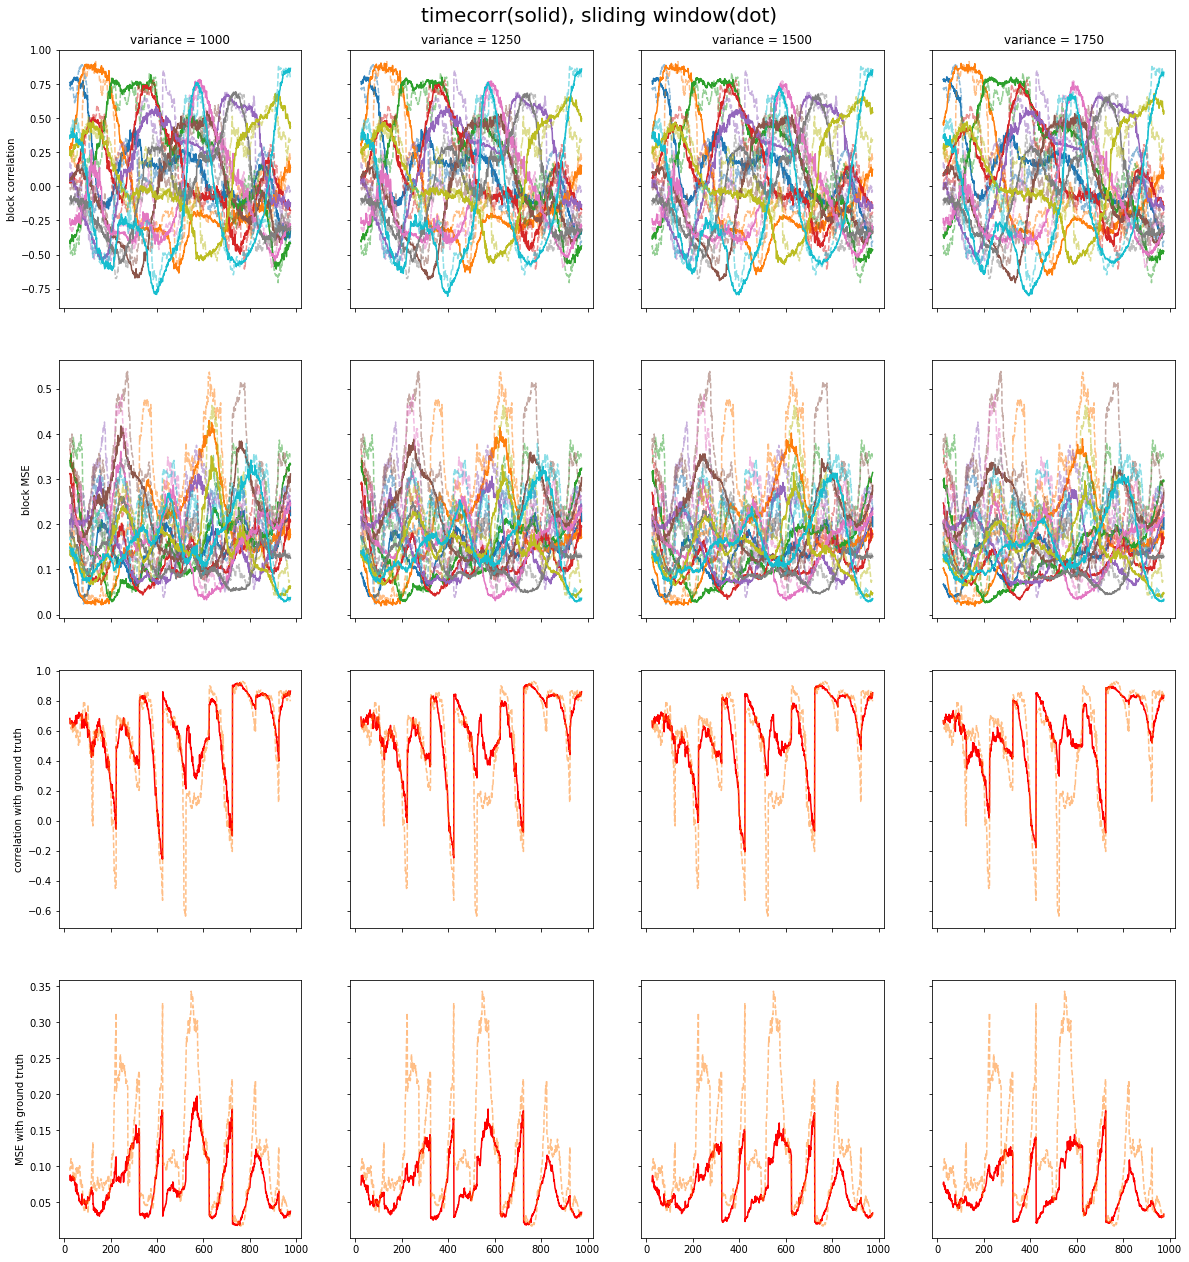

In [1]:
######## timecorr vs sliding window, different variances & block correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [1000,1250,1500,1750]
sliding_window_length = 51
repetitions=1
var_num = len(variance)
block_length = 100
covariance_num = 10
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_block_correlation_data(bl,cn,an):
    global activations, correlations
    block_length = bl
    covariance_num = cn
    activation_num = an
    time_len = block_length * covariance_num
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,1,[activation_num, time_len])

    for i in range(covariance_num):
        while not is_pos_def(correlations[i]):
            temp = np.random.normal(0,1,[activation_num,activation_num])
            correlations[i] = np.dot(temp,temp.T)
            correlations[i] = correlations[i]/np.max(abs(correlations[i]))
    
    for i in range(covariance_num):
        activations[:,(i*block_length):((i+1)*block_length)]=np.dot(cholesky(correlations[i]),activations[:,(i*block_length):((i+1)*block_length)])

lower_limit, upper_limit = sliding_window_length/2, time_len-sliding_window_length/2
time_range = upper_limit - lower_limit

timecorr_correlations = np.zeros([var_num,covariance_num,time_range])
sliding_window_correlations = np.zeros([covariance_num,time_range])

timecorr_MSE = np.zeros([var_num,covariance_num,time_range])
sliding_window_MSE = np.zeros([covariance_num, time_range])

timecorr_correlations_single = np.zeros([var_num,time_range])
sliding_window_correlations_single = np.zeros(time_range)

timecorr_MSE_single = np.zeros([var_num,time_range])
sliding_window_MSE_single = np.zeros(time_range)

true_correlations1,true_correlations2 = np.zeros([covariance_num,time_len]),np.zeros([covariance_num,time_len])
true_MSE1,true_MSE2 = np.zeros([covariance_num,time_len]),np.zeros([covariance_num,time_len])

timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        for v in range(var_num):
            timecorr_recovery[v] = wcorr(activations, variance[v])
        for timepoint in range(time_range):
            sc = pearsonr(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
            sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            sliding_window_MSE[i, timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2]-squareform(correlations[i],checks=False)))
            
            tc1 = pearsonr(squareform(correlations[i,timepoint],checks=False), squareform(correlations[i],checks=False))[0]
            true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
            tc2 = pearsonr(squareform(correlations[i,timepoint],checks=False), squareform(correlations[i],checks=False))[0]
            true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))
            true_MSE1[timepoint]+=np.mean(np.square(correlations[timepoint]-correlations[i]))
            true_MSE2[timepoint]+=np.mean(np.square(correlations[timepoint]-correlations[i]))
            
            for v in range(var_num):
                otc = pearsonr(timecorr_recovery[v,timepoint+lower_limit], squareform(correlations[i],checks=False))[0]
                timecorr_correlations[v,i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
                timecorr_MSE[v, i, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+lower_limit]-squareform(correlations[i],checks=False)))
           
    for timepoint in range(time_range):
        swc = pearsonr(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
        sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        sliding_window_MSE_single[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2]-squareform(correlations[int(timepoint/block_length)],checks=False)))        

        for v in range(var_num):
            otcs = pearsonr(timecorr_recovery[v, timepoint+lower_limit], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+lower_limit]-squareform(correlations[int(timepoint/block_length)],checks=False)))
        

timecorr_correlations /= repetitions
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_MSE /= repetitions
sliding_window_MSE /= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

true_MSE1/= repetitions
true_MSE2/= repetitions

f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("timecorr(solid), sliding window(dot)",fontsize=20)
a1[0].set_title("variance = 1000")
a1[1].set_title("variance = 1250")
a1[2].set_title("variance = 1500")
a1[3].set_title("variance = 1750")
a1[0].set_ylabel("block correlation")
a2[0].set_ylabel("block MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(lower_limit,upper_limit),timecorr_correlations[v,i],c='C'+str(i),alpha=1,linestyle='-')
        a1[v].plot(range(lower_limit,upper_limit),sliding_window_correlations[i],c='C'+str(i),alpha=0.5,linestyle='--')
        a2[v].plot(range(lower_limit,upper_limit),timecorr_MSE[v,i],c='C'+str(i),alpha=1,linestyle='-')
        a2[v].plot(range(lower_limit,upper_limit),sliding_window_MSE[i],c='C'+str(i),alpha=0.5,linestyle='--')

    a3[v].plot(range(lower_limit,upper_limit),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a3[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
    a4[v].plot(range(lower_limit,upper_limit),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')
    a4[v].plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

plt.show()

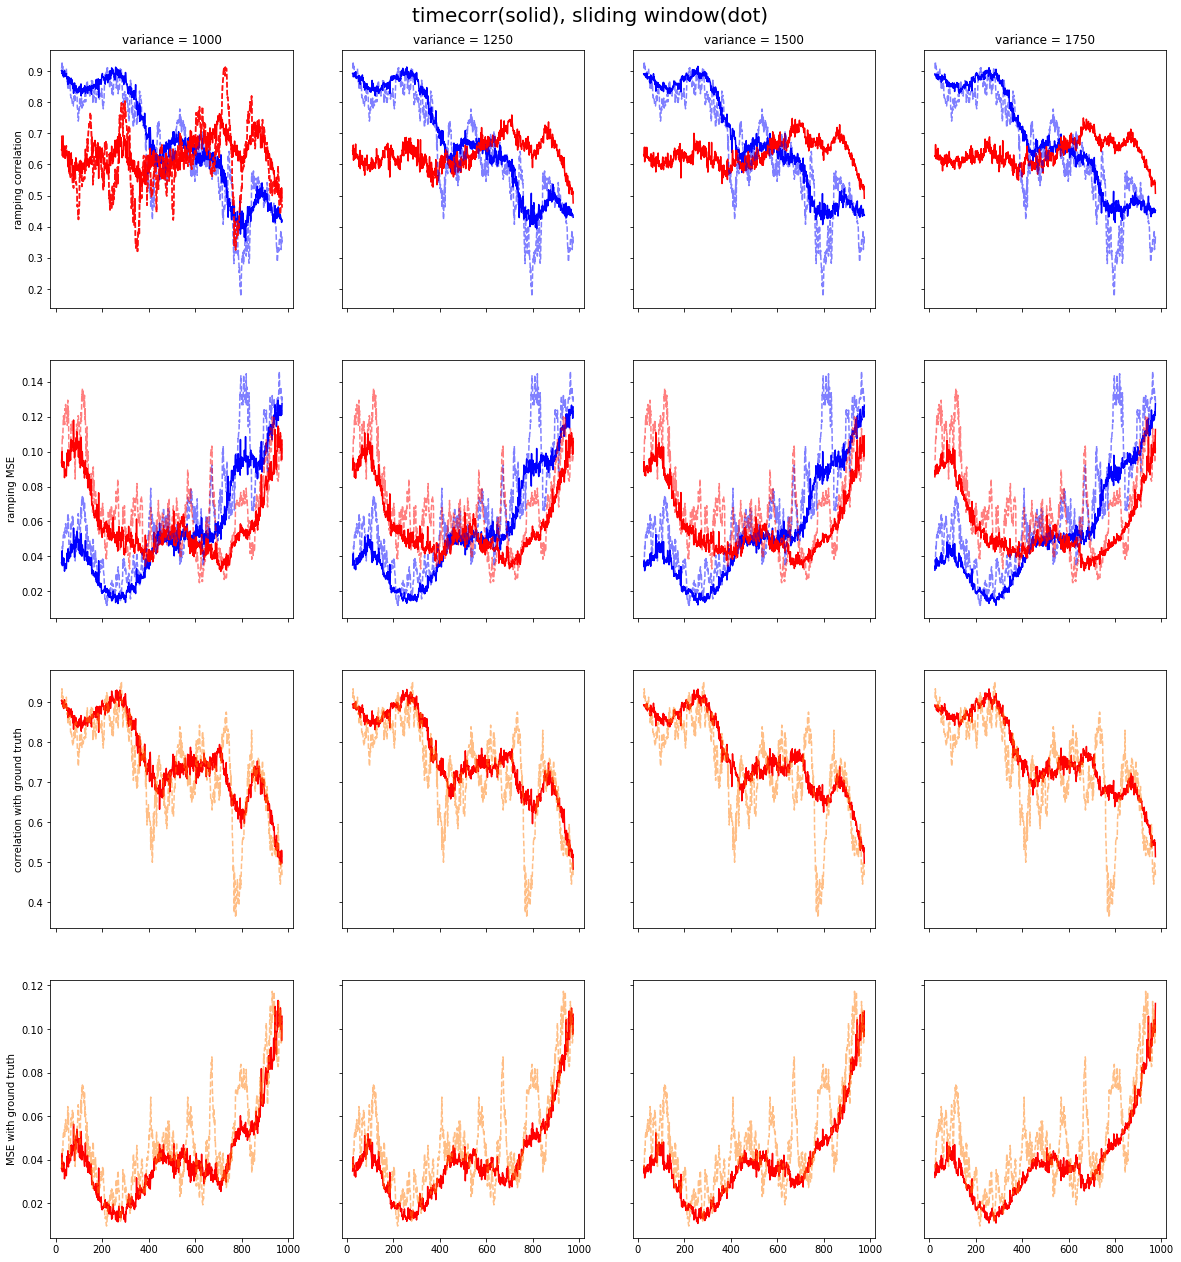

In [2]:
######## timecorr vs sliding window, different variances & ramp correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [1000,1250,1500,1750]
sliding_window_length = 51
repetitions=1
var_num = len(variance)

block_length = 1
covariance_num = 1000
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,10,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map,feature_map.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map1,feature_map1.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])

lower_limit, upper_limit = sliding_window_length/2, time_len-sliding_window_length/2
time_range = upper_limit - lower_limit

timecorr_correlations1,timecorr_correlations2 = np.zeros([var_num,time_len-sliding_window_length+1]),np.zeros([var_num,time_len-sliding_window_length+1])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_MSE1,timecorr_MSE2 = np.zeros([var_num,time_len-sliding_window_length+1]),np.zeros([var_num,time_len-sliding_window_length+1])
sliding_window_MSE1,sliding_window_MSE2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_correlations_single = np.zeros([var_num,time_range])
sliding_window_correlations_single = np.zeros(time_range)

timecorr_MSE_single = np.zeros([var_num,time_range])
sliding_window_MSE_single = np.zeros(time_range)
color = ['b','r']

timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(var_num):
        timecorr_recovery[v] = wcorr(activations,variance[v])
    sliding_window_recovery = sliding_window(activations,sliding_window_length)
    for timepoint in range(time_len-sliding_window_length+1):
        for v in range(var_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            timecorr_MSE1[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
            timecorr_MSE2[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint+sliding_window_length/2], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+sliding_window_length/2]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))
        
        sc1 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation1,checks=False))[0]
        sliding_window_correlations1[timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
        sc2 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation2,checks=False))[0]
        sliding_window_correlations2[timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))
        
        sliding_window_MSE1[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation1,checks=False)))
        sliding_window_MSE2[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation2,checks=False)))
         
        swc = pearsonr(sliding_window_recovery[timepoint], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
        sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        
        sliding_window_MSE_single[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))        

timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions
sliding_window_MSE1/= repetitions
sliding_window_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("timecorr(solid), sliding window(dot)",fontsize=20)
a1[0].set_title("variance = 1000")
a1[1].set_title("variance = 1250")
a1[2].set_title("variance = 1500")
a1[3].set_title("variance = 1750")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(var_num): 
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0)
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0)
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1,c=color[0],linestyle='--',alpha=0.5)
    ax1.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2,c=color[1],linestyle='--',alpha=0.5)

    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE1,c=color[0],linestyle='--',alpha=0.5)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE2,c=color[1],linestyle='--',alpha=0.5)


    a3[v].plot(range(lower_limit,upper_limit),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a3[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
    a4[v].plot(range(lower_limit,upper_limit),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')
    a4[v].plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

plt.show()

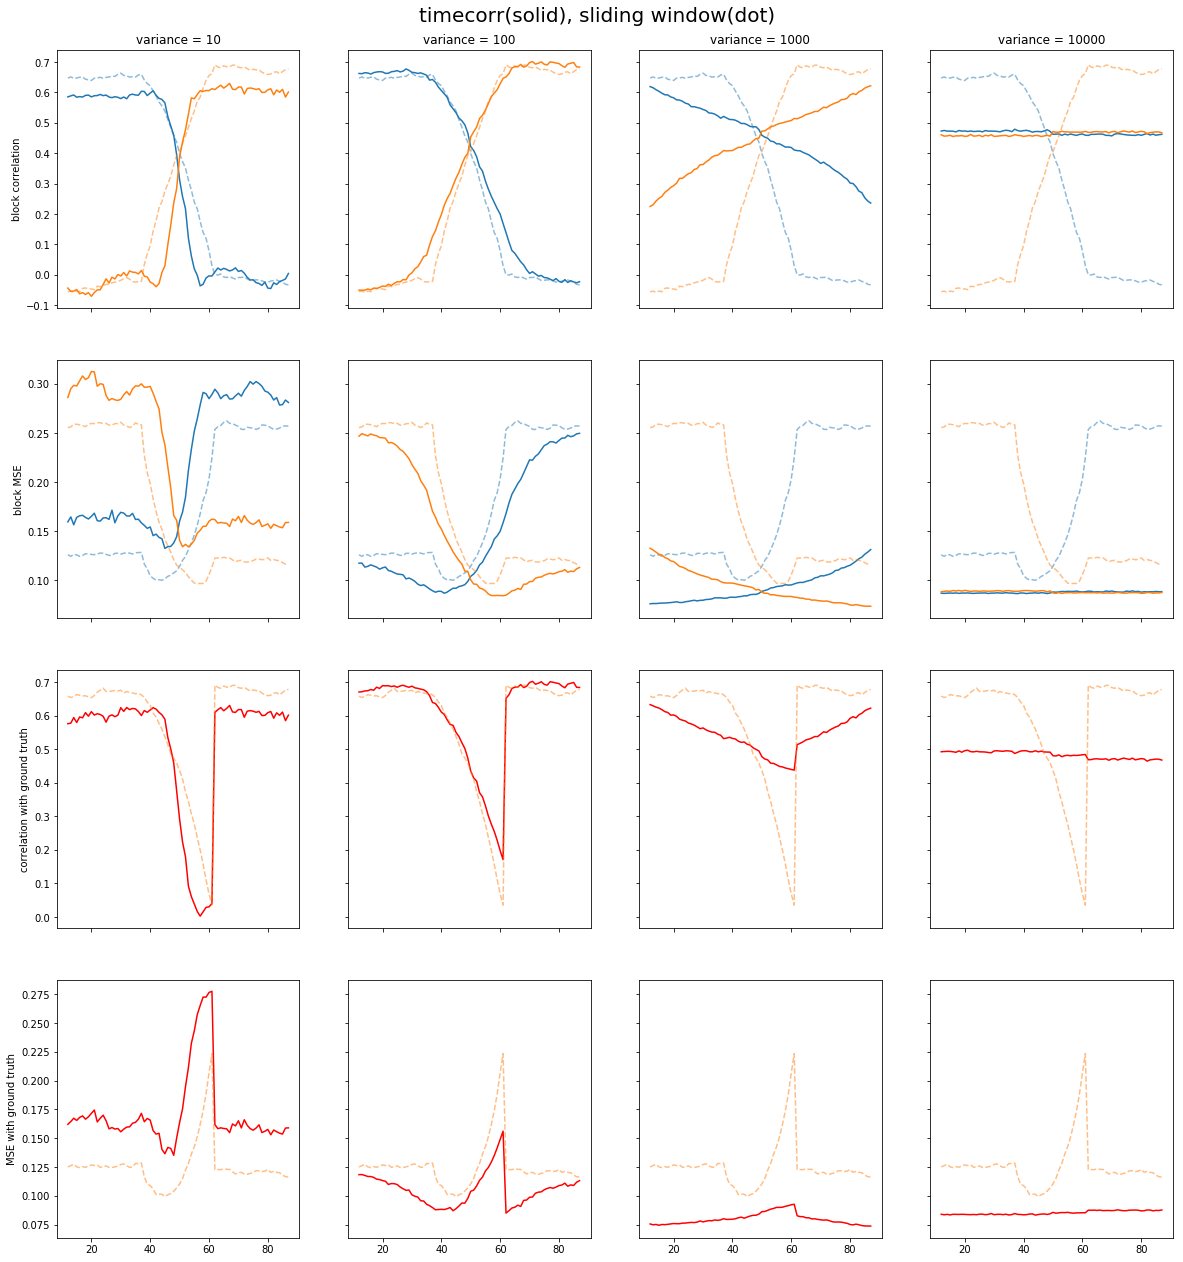

In [5]:
##### timecorr vs sliding window, different variances and short time length, block correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [10,100,1000,10000]
sliding_window_length = 25
repetitions=100
var_num = len(variance)
block_length = 50
covariance_num = 2
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_block_correlation_data(bl,cn,an):
    global activations, correlations
    block_length = bl
    covariance_num = cn
    activation_num = an
    time_len = block_length * covariance_num
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,1,[activation_num, time_len])

    for i in range(covariance_num):
        while not is_pos_def(correlations[i]):
            temp = np.random.normal(0,1,[activation_num,activation_num])
            correlations[i] = np.dot(temp,temp.T)
            correlations[i] = correlations[i]/np.max(abs(correlations[i]))
    
    for i in range(covariance_num):
        activations[:,(i*block_length):((i+1)*block_length)]=np.dot(cholesky(correlations[i]),activations[:,(i*block_length):((i+1)*block_length)])

lower_limit, upper_limit = sliding_window_length/2, time_len-sliding_window_length/2
time_range = upper_limit - lower_limit

timecorr_correlations = np.zeros([var_num,covariance_num,time_range])
sliding_window_correlations = np.zeros([covariance_num,time_range])

timecorr_MSE = np.zeros([var_num,covariance_num,time_range])
sliding_window_MSE = np.zeros([covariance_num, time_range])

timecorr_correlations_single = np.zeros([var_num,time_range])
sliding_window_correlations_single = np.zeros(time_range)

timecorr_MSE_single = np.zeros([var_num,time_range])
sliding_window_MSE_single = np.zeros(time_range)

timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        for v in range(var_num):
            timecorr_recovery[v] = wcorr(activations, variance[v])
        for timepoint in range(time_range):
            sc = pearsonr(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
            sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            sliding_window_MSE[i, timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2]-squareform(correlations[i],checks=False)))
            
            for v in range(var_num):
                otc = pearsonr(timecorr_recovery[v,timepoint+lower_limit], squareform(correlations[i],checks=False))[0]
                timecorr_correlations[v,i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
                timecorr_MSE[v, i, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+lower_limit]-squareform(correlations[i],checks=False)))
           
    for timepoint in range(time_range):
        swc = pearsonr(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
        sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        sliding_window_MSE_single[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2]-squareform(correlations[int(timepoint/block_length)],checks=False)))        

        for v in range(var_num):
            otcs = pearsonr(timecorr_recovery[v, timepoint+lower_limit], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+lower_limit]-squareform(correlations[int(timepoint/block_length)],checks=False)))
        

timecorr_correlations /= repetitions
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_MSE /= repetitions
sliding_window_MSE /= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("timecorr(solid), sliding window(dot)",fontsize=20)
a1[0].set_title("variance = 10")
a1[1].set_title("variance = 100")
a1[2].set_title("variance = 1000")
a1[3].set_title("variance = 10000")
a1[0].set_ylabel("block correlation")
a2[0].set_ylabel("block MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(var_num): 
    for i in range(covariance_num):
        a1[v].plot(range(lower_limit,upper_limit),timecorr_correlations[v,i],c='C'+str(i),alpha=1,linestyle='-')
        a1[v].plot(range(lower_limit,upper_limit),sliding_window_correlations[i],c='C'+str(i),alpha=0.5,linestyle='--')
        a2[v].plot(range(lower_limit,upper_limit),timecorr_MSE[v,i],c='C'+str(i),alpha=1,linestyle='-')
        a2[v].plot(range(lower_limit,upper_limit),sliding_window_MSE[i],c='C'+str(i),alpha=0.5,linestyle='--')

    a3[v].plot(range(lower_limit,upper_limit),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a3[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
    a4[v].plot(range(lower_limit,upper_limit),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')
    a4[v].plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

plt.show()

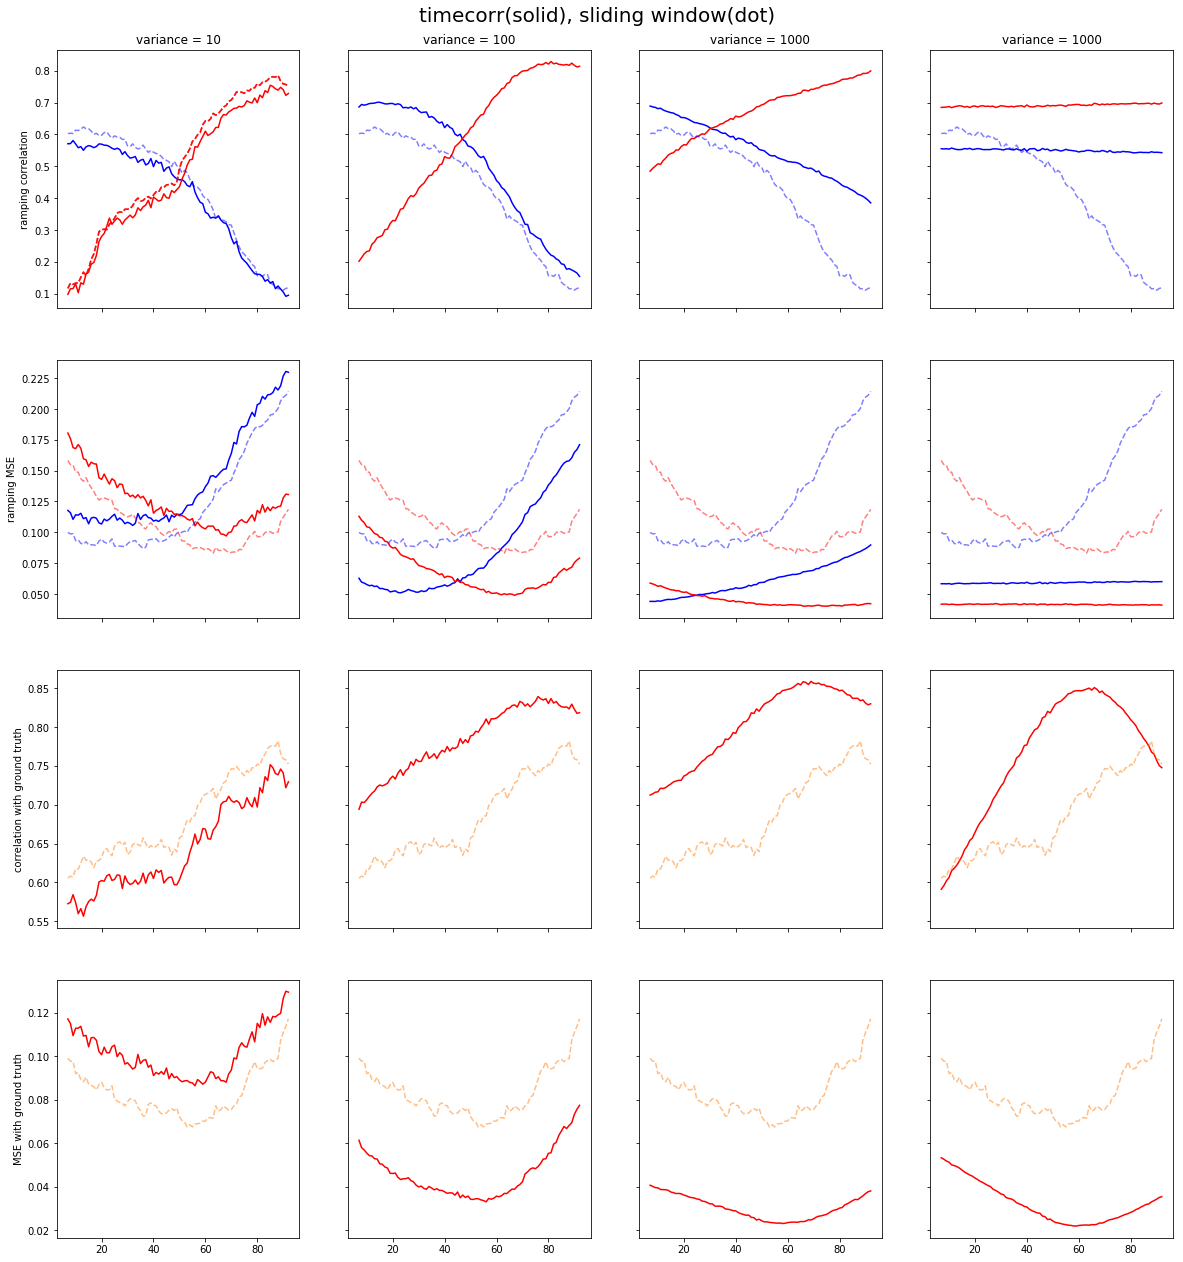

In [4]:
##### timecorr vs sliding window, different variances and short time length, ramp correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = [10,100,1000,10000]
sliding_window_length = 15
repetitions=100
var_num = len(variance)

block_length = 1
covariance_num = 100
time_len = block_length * covariance_num
activation_num = 5
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,10,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map,feature_map.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map1,feature_map1.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])

lower_limit, upper_limit = sliding_window_length/2, time_len-sliding_window_length/2
time_range = upper_limit - lower_limit

timecorr_correlations1,timecorr_correlations2 = np.zeros([var_num,time_len-sliding_window_length+1]),np.zeros([var_num,time_len-sliding_window_length+1])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_MSE1,timecorr_MSE2 = np.zeros([var_num,time_len-sliding_window_length+1]),np.zeros([var_num,time_len-sliding_window_length+1])
sliding_window_MSE1,sliding_window_MSE2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_correlations_single = np.zeros([var_num,time_range])
sliding_window_correlations_single = np.zeros(time_range)

timecorr_MSE_single = np.zeros([var_num,time_range])
sliding_window_MSE_single = np.zeros(time_range)
color = ['b','r']

timecorr_recovery = np.zeros([var_num,time_len,(activation_num * (activation_num-1) / 2)])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(var_num):
        timecorr_recovery[v] = wcorr(activations,variance[v])
    sliding_window_recovery = sliding_window(activations,sliding_window_length)
    for timepoint in range(time_len-sliding_window_length+1):
        for v in range(var_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            timecorr_MSE1[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
            timecorr_MSE2[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint+sliding_window_length/2], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+sliding_window_length/2]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))
        
        sc1 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation1,checks=False))[0]
        sliding_window_correlations1[timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
        sc2 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation2,checks=False))[0]
        sliding_window_correlations2[timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))
        
        sliding_window_MSE1[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation1,checks=False)))
        sliding_window_MSE2[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation2,checks=False)))
         
        swc = pearsonr(sliding_window_recovery[timepoint], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
        sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        
        sliding_window_MSE_single[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))        

timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions
sliding_window_MSE1/= repetitions
sliding_window_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("timecorr(solid), sliding window(dot)",fontsize=20)
a1[0].set_title("variance = 10")
a1[1].set_title("variance = 100")
a1[2].set_title("variance = 1000")
a1[3].set_title("variance = 10000")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(var_num): 
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0)
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0)
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1,c=color[0],linestyle='--',alpha=0.5)
    ax1.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2,c=color[1],linestyle='--',alpha=0.5)

    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE1,c=color[0],linestyle='--',alpha=0.5)
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE2,c=color[1],linestyle='--',alpha=0.5)


    a3[v].plot(range(lower_limit,upper_limit),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a3[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
    a4[v].plot(range(lower_limit,upper_limit),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')
    a4[v].plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

plt.show()

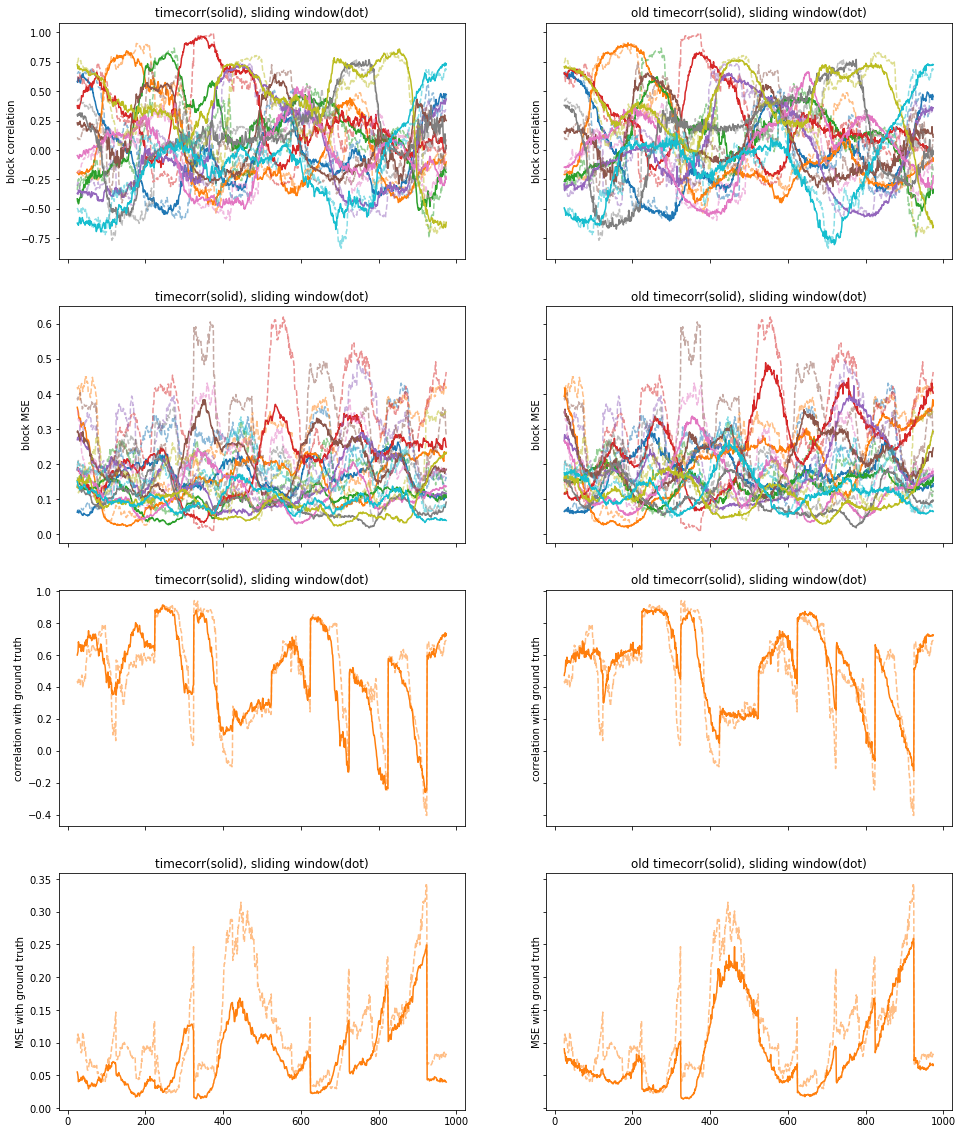

In [4]:
#### timecorr vs old timecorr, block correlations
from _shared.helpers import wcorr, sliding_window, old_timecorr
import matplotlib.pyplot as plt
from math import log
import numpy as np
variance = 1000
CFER = 3
sliding_window_length = 51
repetitions=1

lower_limit, upper_limit = sliding_window_length/2, time_len-sliding_window_length/2
time_range = upper_limit - lower_limit
timecorr_correlations = np.zeros([covariance_num,time_range])
old_timecorr_correlations = np.zeros([covariance_num,time_range])
sliding_window_correlations = np.zeros([covariance_num,time_range])

timecorr_MSE = np.zeros([covariance_num,time_range])
old_timecorr_MSE = np.zeros([covariance_num,time_range])
sliding_window_MSE = np.zeros([covariance_num, time_range])

timecorr_correlations_single = np.zeros(time_range)
old_timecorr_correlations_single = np.zeros(time_range)
sliding_window_correlations_single = np.zeros(time_range)

timecorr_MSE_single = np.zeros(time_range)
old_timecorr_MSE_single = np.zeros(time_range)
sliding_window_MSE_single = np.zeros(time_range)

for r in range(repetitions):
    for i in range(covariance_num):
        cholesky_block_correlation_data(block_length,covariance_num,activation_num)
        timecorr_recovery = wcorr(activations,variance,CFER)
        sliding_window_recovery = sliding_window(activations,sliding_window_length)
        old_timecorr_recovery = old_timecorr(activations, variance)
        for timepoint in range(time_range):
            tc = pearsonr(timecorr_recovery[timepoint+lower_limit], squareform(correlations[i],checks=False))[0]
            timecorr_correlations[i,timepoint] += 0.5 * (log(1+tc) - log(1-tc))
            sc = pearsonr(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2], squareform(correlations[i],checks=False))[0]
            sliding_window_correlations[i,timepoint] += 0.5 * (log(1+sc) - log(1-sc))
            otc = pearsonr(old_timecorr_recovery[timepoint+lower_limit], squareform(correlations[i],checks=False))[0]
            old_timecorr_correlations[i,timepoint] += 0.5 * (log(1+otc) - log(1-otc))
            
            timecorr_MSE[i, timepoint]+=np.mean(np.square(timecorr_recovery[timepoint+lower_limit]-squareform(correlations[i],checks=False)))
            sliding_window_MSE[i, timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2]-squareform(correlations[i],checks=False)))
            old_timecorr_MSE[i, timepoint]+=np.mean(np.square(old_timecorr_recovery[timepoint+lower_limit]-squareform(correlations[i],checks=False)))
            
    for timepoint in range(time_range):
        tcs = pearsonr(timecorr_recovery[timepoint+lower_limit], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
        timecorr_correlations_single[timepoint]+= 0.5 * (log(1+tcs) - log(1-tcs))
        swc = pearsonr(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
        sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        otcs = pearsonr(old_timecorr_recovery[timepoint+lower_limit], squareform(correlations[int(timepoint/block_length)],checks=False))[0]
        old_timecorr_correlations_single[timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
        
        timecorr_MSE_single[timepoint]+=np.mean(np.square(timecorr_recovery[timepoint+lower_limit]-squareform(correlations[int(timepoint/block_length)],checks=False)))
        sliding_window_MSE_single[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint+lower_limit-sliding_window_length/2]-squareform(correlations[int(timepoint/block_length)],checks=False)))        
        old_timecorr_MSE_single[timepoint]+=np.mean(np.square(old_timecorr_recovery[timepoint+lower_limit]-squareform(correlations[int(timepoint/block_length)],checks=False)))
        
timecorr_correlations /= repetitions
timecorr_correlations = (np.exp(2*timecorr_correlations) - 1)/(np.exp(2*timecorr_correlations) + 1)

old_timecorr_correlations /= repetitions
old_timecorr_correlations = (np.exp(2*old_timecorr_correlations) - 1)/(np.exp(2*old_timecorr_correlations) + 1)

sliding_window_correlations /= repetitions
sliding_window_correlations = (np.exp(2*sliding_window_correlations) - 1)/(np.exp(2*sliding_window_correlations) + 1)

timecorr_MSE /= repetitions
old_timecorr_MSE /= repetitions
sliding_window_MSE /= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
old_timecorr_correlations_single /= repetitions
old_timecorr_correlations_single = (np.exp(2*old_timecorr_correlations_single) - 1)/(np.exp(2*old_timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 
timecorr_MSE_single /= repetitions
old_timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions


f, ((ax1,ax5),(ax2,ax6),(ax3,ax7),(ax4,ax8)) = plt.subplots(4,2, sharex=True, sharey='row', figsize=(16,20))
ax1.set_title("timecorr(solid), sliding window(dot)")
ax2.set_title("timecorr(solid), sliding window(dot)")
ax1.set_ylabel("block correlation")
ax2.set_ylabel("block MSE")
for i in range(covariance_num):
    ax1.plot(range(lower_limit,upper_limit),timecorr_correlations[i],c='C'+str(i),alpha=1,linestyle='-')
    ax1.plot(range(lower_limit,upper_limit),sliding_window_correlations[i],c='C'+str(i),alpha=0.5,linestyle='--')
    ax2.plot(range(lower_limit,upper_limit),timecorr_MSE[i],c='C'+str(i),alpha=1,linestyle='-')
    ax2.plot(range(lower_limit,upper_limit),sliding_window_MSE[i],c='C'+str(i),alpha=0.5,linestyle='--')

ax3.set_title("timecorr(solid), sliding window(dot)")
ax4.set_title("timecorr(solid), sliding window(dot)")
ax3.set_ylabel("correlation with ground truth")
ax4.set_ylabel("MSE with ground truth")   
ax3.plot(range(lower_limit,upper_limit),timecorr_correlations_single,c='C1',alpha=1,linestyle='-')
ax3.plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
ax4.plot(range(lower_limit,upper_limit),timecorr_MSE_single,c='C1',alpha=1,linestyle='-')
ax4.plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')


ax5.set_title("old timecorr(solid), sliding window(dot)")
ax6.set_title("old timecorr(solid), sliding window(dot)")
ax5.set_ylabel("block correlation")
ax6.set_ylabel("block MSE")
for i in range(covariance_num):
    ax5.plot(range(lower_limit,upper_limit),old_timecorr_correlations[i],c='C'+str(i),alpha=1,linestyle='-')
    ax5.plot(range(lower_limit,upper_limit),sliding_window_correlations[i],c='C'+str(i),alpha=0.5,linestyle='--')
    ax6.plot(range(lower_limit,upper_limit),old_timecorr_MSE[i],c='C'+str(i),alpha=1,linestyle='-')
    ax6.plot(range(lower_limit,upper_limit),sliding_window_MSE[i],c='C'+str(i),alpha=0.5,linestyle='--')

ax7.set_title("old timecorr(solid), sliding window(dot)")
ax8.set_title("old timecorr(solid), sliding window(dot)")
ax7.set_ylabel("correlation with ground truth")
ax8.set_ylabel("MSE with ground truth")   
ax7.plot(range(lower_limit,upper_limit),old_timecorr_correlations_single,c='C1',alpha=1,linestyle='-')
ax7.plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
ax8.plot(range(lower_limit,upper_limit),old_timecorr_MSE_single,c='C1',alpha=1,linestyle='-')
ax8.plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

plt.show()

In [2]:
#### timecorr vs old timecorr, ramp correlation
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
variance = 1000
CFER = 3
sliding_window_length = 51
repetitions=1

timecorr_correlations1,timecorr_correlations2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)
old_timecorr_correlations1,old_timecorr_correlations2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)
sliding_window_correlations1,sliding_window_correlations2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_MSE1,timecorr_MSE2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)
old_timecorr_MSE1,old_timecorr_MSE2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)
sliding_window_MSE1,sliding_window_MSE2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)

timecorr_correlations_single = np.zeros(time_range)
old_timecorr_correlations_single = np.zeros(time_range)
sliding_window_correlations_single = np.zeros(time_range)

timecorr_MSE_single = np.zeros(time_range)
old_timecorr_MSE_single = np.zeros(time_range)
sliding_window_MSE_single = np.zeros(time_range)
color = ['b','r']

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    timecorr_recovery = wcorr(activations,variance,CFER)
    old_timecorr_recovery = old_timecorr(activations,variance)
    sliding_window_recovery = sliding_window(activations,sliding_window_length)
    for timepoint in range(time_len-sliding_window_length+1):
        tc1 = pearsonr(timecorr_recovery[timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
        timecorr_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1))
        tc2 = pearsonr(timecorr_recovery[timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
        timecorr_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2))
        otc1 = pearsonr(old_timecorr_recovery[timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
        old_timecorr_correlations1[timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
        otc2 = pearsonr(old_timecorr_recovery[timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
        old_timecorr_correlations2[timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
        sc1 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation1,checks=False))[0]
        sliding_window_correlations1[timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
        sc2 = pearsonr(sliding_window_recovery[timepoint], squareform(correlation2,checks=False))[0]
        sliding_window_correlations2[timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))
        
        timecorr_MSE1[timepoint]+=np.mean(np.square(timecorr_recovery[timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
        timecorr_MSE2[timepoint]+=np.mean(np.square(timecorr_recovery[timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))
        old_timecorr_MSE1[timepoint]+=np.mean(np.square(old_timecorr_recovery[timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
        old_timecorr_MSE2[timepoint]+=np.mean(np.square(old_timecorr_recovery[timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))
        sliding_window_MSE1[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation1,checks=False)))
        sliding_window_MSE2[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlation2,checks=False)))
        
        tcs = pearsonr(timecorr_recovery[timepoint+sliding_window_length/2], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
        timecorr_correlations_single[timepoint]+= 0.5 * (log(1+tcs) - log(1-tcs))
        otcs = pearsonr(old_timecorr_recovery[timepoint+sliding_window_length/2], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
        old_timecorr_correlations_single[timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
        swc = pearsonr(sliding_window_recovery[timepoint], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
        sliding_window_correlations_single[timepoint] += 0.5 * (log(1+swc) - log(1-swc))
        
        timecorr_MSE_single[timepoint]+=np.mean(np.square(timecorr_recovery[timepoint+sliding_window_length/2]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))
        old_timecorr_MSE_single[timepoint]+=np.mean(np.square(old_timecorr_recovery[timepoint+sliding_window_length/2]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))
        sliding_window_MSE_single[timepoint]+=np.mean(np.square(sliding_window_recovery[timepoint]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))        

timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

old_timecorr_correlations1 /= repetitions
old_timecorr_correlations1 =  (np.exp(2*old_timecorr_correlations1) - 1)/(np.exp(2*old_timecorr_correlations1) + 1)

old_timecorr_correlations2 /= repetitions
old_timecorr_correlations2 =  (np.exp(2*old_timecorr_correlations2) - 1)/(np.exp(2*old_timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions
old_timecorr_MSE1/= repetitions
old_timecorr_MSE2/= repetitions
sliding_window_MSE1/= repetitions
sliding_window_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
old_timecorr_correlations_single /= repetitions
old_timecorr_correlations_single = (np.exp(2*old_timecorr_correlations_single) - 1)/(np.exp(2*old_timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 

timecorr_MSE_single /= repetitions
old_timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions

f, ((ax1,ax5),(ax2,ax6),(ax3,ax7),(ax4,ax8)) = plt.subplots(4,2, sharex=True, sharey='row', figsize=(16,20))
ax1.set_ylabel("ramping correlation")
ax1.set_title("timecorr(solid), sliding window(dot)")
ax1.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations1,c=color[0],linestyle='-',alpha=1.0)
ax1.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations2,c=color[1],linestyle='-',alpha=1.0)
ax1.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1,c=color[0],linestyle='--',alpha=0.5)
ax1.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2,c=color[1],linestyle='--',alpha=0.5)

ax2.set_ylabel("ramping MSE")
ax2.set_title("timecorr(solid), sliding window(dot)")
ax2.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE1,c=color[0],linestyle='-',alpha=1.0)
ax2.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE2,c=color[1],linestyle='-',alpha=1.0)
ax2.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE1,c=color[0],linestyle='--',alpha=0.5)
ax2.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE2,c=color[1],linestyle='--',alpha=0.5)

    
ax3.set_title("timecorr(solid), sliding window(dot)")
ax4.set_title("timecorr(solid), sliding window(dot)")
ax3.set_ylabel("correlation with ground truth")
ax4.set_ylabel("MSE with ground truth")   
ax3.plot(range(lower_limit,upper_limit),timecorr_correlations_single,c='C1',alpha=1,linestyle='-')
ax3.plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
ax4.plot(range(lower_limit,upper_limit),timecorr_MSE_single,c='C1',alpha=1,linestyle='-')
ax4.plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

ax5.set_ylabel("ramping correlation")
ax5.set_title("old_timecorr(solid), sliding window(dot)")
ax5.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),old_timecorr_correlations1,c=color[0],linestyle='-',alpha=1.0)
ax5.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),old_timecorr_correlations2,c=color[1],linestyle='-',alpha=1.0)
ax5.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1,c=color[0],linestyle='--',alpha=0.5)
ax5.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2,c=color[1],linestyle='--',alpha=0.5)

ax6.set_ylabel("ramping MSE")
ax6.set_title("old_timecorr(solid), sliding window(dot)")
ax6.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),old_timecorr_MSE1,c=color[0],linestyle='-',alpha=1.0)
ax6.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),old_timecorr_MSE2,c=color[1],linestyle='-',alpha=1.0)
ax6.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE1,c=color[0],linestyle='--',alpha=0.5)
ax6.plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE2,c=color[1],linestyle='--',alpha=0.5)

    
ax7.set_title("old_timecorr(solid), sliding window(dot)")
ax7.set_ylabel("correlation with ground truth")
ax8.set_title("old_timecorr(solid), sliding window(dot)")
ax8.set_ylabel("MSE with ground truth")   
ax7.plot(range(lower_limit,upper_limit),old_timecorr_correlations_single,c='C1',alpha=1,linestyle='-')
ax7.plot(range(lower_limit,upper_limit),sliding_window_correlations_single,c='C1',alpha=0.5,linestyle='--')
ax8.plot(range(lower_limit,upper_limit),old_timecorr_MSE_single,c='C1',alpha=1,linestyle='-')
ax8.plot(range(lower_limit,upper_limit),sliding_window_MSE_single,c='C1',alpha=0.5,linestyle='--')

plt.show()

NameError: name 'time_range' is not defined